In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"faizullovairat","key":"d14fe7a00bebfdb3604c6d1cab831f75"}'}

In [3]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c aim-2023

 36% 5.00M/13.8M [00:00<00:00, 36.7MB/s]
100% 13.8M/13.8M [00:00<00:00, 78.2MB/s]


In [4]:
! unzip aim-2023

Archive:  aim-2023.zip
  inflating: distance_from_to.csv    
  inflating: submission.csv          
  inflating: train.parquet           


In [5]:
tr = pd.read_parquet('train.parquet')
sample_submission = pd.read_csv('submission.csv')

In [6]:
# tr

,Values
0_0_0,133.0
0_0_1,114.0
0_0_2,140.0
0_0_3,106.0
0_0_4,117.0
...,...
169_2_17751,65.5
169_2_17752,65.5
169_2_17753,64.9
169_2_17754,64.7


In [7]:
'''
pd.Index - это нечто очень похожее на pd.Series
Так что все, что вы хотели бы сделать с индексом, как если бы он был pd.Series,
    скорее всего можно сделать...
'''
index_split = tr.index.str.split('_')
index_split

Index([      ['0', '0', '0'],       ['0', '0', '1'],       ['0', '0', '2'],
             ['0', '0', '3'],       ['0', '0', '4'],       ['0', '0', '5'],
             ['0', '0', '6'],       ['0', '0', '7'],       ['0', '0', '8'],
             ['0', '0', '9'],
       ...
       ['169', '2', '17746'], ['169', '2', '17747'], ['169', '2', '17748'],
       ['169', '2', '17749'], ['169', '2', '17750'], ['169', '2', '17751'],
       ['169', '2', '17752'], ['169', '2', '17753'], ['169', '2', '17754'],
       ['169', '2', '17755']],
      dtype='object', length=9055560)

In [8]:
'''
#забавно
У колонок из листов в пандасе тоже есть .str API.
Вытащить i-й элемент списка по всем колонкам можно через .str.get(i)
'''
tr['row_num'] = index_split.str.get(0)
tr['row_type'] = index_split.str.get(1)
tr['timestamp'] = index_split.str.get(-1).astype(int)
tr['row_id'] = tr.row_num + '_' + tr.row_type # "уникальный" ряд - уникальная пара (row_num, row_type)
tr # в таком виде можно сохранить себе на диск в .parquet, чтобы не делать долгих операций каждый раз

,Values,row_num,row_type,timestamp,row_id
0_0_0,133.0,0,0,0,0_0
0_0_1,114.0,0,0,1,0_0
0_0_2,140.0,0,0,2,0_0
0_0_3,106.0,0,0,3,0_0
0_0_4,117.0,0,0,4,0_0
...,...,...,...,...,...
169_2_17751,65.5,169,2,17751,169_2
169_2_17752,65.5,169,2,17752,169_2
169_2_17753,64.9,169,2,17753,169_2
169_2_17754,64.7,169,2,17754,169_2


In [9]:
'''
Формат не особо удобен, т.к. мы привыкли, что один объект изучения - одна строка.
Почти любую ситуацию вида "данные что надо, а формат не совсем подходящий"
    pandas умеет решать в одну-две строчки.
'''
X = tr.pivot(index='row_id', columns='timestamp', values='Values') # это быстро

'''
Видим, что сортировочка индекса поехала из-за того что .pivot зачем-то сортирует индекс и колонки
    (для этого перевели timestamp в int)
'''
X

timestamp,0,1,2,3,4,5,6,7,8,9,...,17746,17747,17748,17749,17750,17751,17752,17753,17754,17755
row_id,,,,,,,,,,,,,,,,,,,,,
0_0,133.0000,114.0000,140.0000,106.0000,117.0000,110.0000,130.0000,112.0000,115.0000,93.0000,...,446.0000,468.0000,447.0000,443.0000,476.0000,509.0000,462.0000,412.0000,429.0000,430.0000
0_1,0.0603,0.0532,0.0622,0.0452,0.0574,0.0545,0.0566,0.0606,0.0479,0.0477,...,0.1498,0.1595,0.1527,0.1491,0.1554,0.1643,0.1621,0.1450,0.1480,0.1488
0_2,65.8000,66.9000,66.8000,68.9000,67.4000,65.5000,66.4000,63.0000,67.3000,65.7000,...,61.6000,61.7000,61.8000,62.5000,62.4000,62.7000,62.7000,62.5000,62.3000,61.8000
100_0,124.0000,125.0000,127.0000,121.0000,121.0000,132.0000,124.0000,116.0000,116.0000,118.0000,...,261.0000,281.0000,222.0000,254.0000,284.0000,286.0000,264.0000,281.0000,288.0000,291.0000
100_1,0.0493,0.0475,0.0486,0.0481,0.0478,0.0496,0.0446,0.0467,0.0443,0.0494,...,0.0873,0.0932,0.0763,0.0874,0.0970,0.0905,0.0824,0.0915,0.0985,0.1079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99_1,0.0472,0.0425,0.0491,0.0449,0.0421,0.0526,0.0474,0.0495,0.0403,0.0504,...,0.0848,0.0901,0.0935,0.0825,0.0894,0.0941,0.0950,0.0864,0.0924,0.0833
99_2,64.1000,63.4000,62.2000,62.4000,64.3000,61.4000,61.1000,59.1000,61.0000,57.9000,...,58.4000,56.8000,58.0000,58.9000,57.8000,58.4000,57.3000,57.5000,57.0000,59.3000
9_0,256.0000,210.0000,224.0000,208.0000,188.0000,211.0000,178.0000,189.0000,169.0000,171.0000,...,670.0000,789.0000,769.0000,655.0000,690.0000,732.0000,684.0000,684.0000,724.0000,744.0000


In [10]:
X.columns = ['tr_' + str(col) for col in X.columns]
X.head(5) # исправим ситуацию

,tr_0,tr_1,tr_2,tr_3,tr_4,tr_5,tr_6,tr_7,tr_8,tr_9,...,tr_17746,tr_17747,tr_17748,tr_17749,tr_17750,tr_17751,tr_17752,tr_17753,tr_17754,tr_17755
row_id,,,,,,,,,,,,,,,,,,,,,
0_0,133.0000,114.0000,140.0000,106.0000,117.0000,110.0000,130.0000,112.0000,115.0000,93.0000,...,446.0000,468.0000,447.0000,443.0000,476.0000,509.0000,462.0000,412.0000,429.0000,430.0000
0_1,0.0603,0.0532,0.0622,0.0452,0.0574,0.0545,0.0566,0.0606,0.0479,0.0477,...,0.1498,0.1595,0.1527,0.1491,0.1554,0.1643,0.1621,0.1450,0.1480,0.1488
0_2,65.8000,66.9000,66.8000,68.9000,67.4000,65.5000,66.4000,63.0000,67.3000,65.7000,...,61.6000,61.7000,61.8000,62.5000,62.4000,62.7000,62.7000,62.5000,62.3000,61.8000
100_0,124.0000,125.0000,127.0000,121.0000,121.0000,132.0000,124.0000,116.0000,116.0000,118.0000,...,261.0000,281.0000,222.0000,254.0000,284.0000,286.0000,264.0000,281.0000,288.0000,291.0000
100_1,0.0493,0.0475,0.0486,0.0481,0.0478,0.0496,0.0446,0.0467,0.0443,0.0494,...,0.0873,0.0932,0.0763,0.0874,0.0970,0.0905,0.0824,0.0915,0.0985,0.1079


## MASE calculation

In [11]:
def calculate_weights(data):
    """
    Функция для расчета весов для каждого ряда
    """
    weights = []
    for i in range(data.shape[0]):
        ts = data.values[i, :]
        weight = np.mean(np.abs(np.diff(ts)))
        weights.append(1 / weight)
    return np.array(weights)


def calculate_mase(y_true, y_pred, weight):
    """
    Функция для расчета метрики MASE для каждого ряда
    """
    n = len(y_true)
    mase = np.sum(weight * np.abs(y_true - y_pred)) / n
    return mase

In [12]:
weights = calculate_weights(X)    # нашли веса для каждой строки

In [13]:
len(weights)

510

### Solution for 1st baseline

In [14]:
tmp_table = X.copy()
tmp_table_test = X.copy()
for i in range(100):
    tmp_table.loc[:, f'pred_{i}'] = 0.45*tmp_table.iloc[:, -2016] + tmp_table.iloc[:, -288] * 0.50 + tmp_table.iloc[:, -1] * 0.03 + tmp_table.iloc[:, -2] * 0.02

tmp_table.iloc[:, -105:]

<ipython-input-14-58a3dc823dbe>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tmp_table.loc[:, f'pred_{i}'] = 0.45*tmp_table.iloc[:, -2016] + tmp_table.iloc[:, -288] * 0.50 + tmp_table.iloc[:, -1] * 0.03 + tmp_table.iloc[:, -2] * 0.02


,tr_17751,tr_17752,tr_17753,tr_17754,tr_17755,pred_0,pred_1,pred_2,pred_3,pred_4,...,pred_90,pred_91,pred_92,pred_93,pred_94,pred_95,pred_96,pred_97,pred_98,pred_99
row_id,,,,,,,,,,,,,,,,,,,,,
0_0,509.0000,462.0000,412.0000,429.0000,430.0000,481.180000,456.285400,480.762162,487.098573,453.978200,...,139.863559,136.108507,131.330526,132.412086,121.548973,115.344711,125.891321,114.683634,121.908335,108.700923
0_1,0.1643,0.1621,0.1450,0.1480,0.1488,0.159949,0.155824,0.157439,0.156580,0.142726,...,0.060491,0.063277,0.060763,0.061058,0.054452,0.058545,0.058030,0.058557,0.057222,0.053633
0_2,62.7000,62.7000,62.5000,62.3000,61.8000,62.445000,62.079350,62.481281,63.231025,64.141556,...,67.453312,64.860008,64.419866,64.459796,64.742191,63.911462,64.617188,63.876745,63.163646,63.662444
100_0,286.0000,264.0000,281.0000,288.0000,291.0000,296.290000,283.358700,300.276561,288.225471,287.002295,...,138.921684,155.049469,133.279918,140.799387,127.989580,140.155675,125.714462,123.974547,127.533526,127.705497
100_1,0.0905,0.0824,0.0915,0.0985,0.1079,0.098217,0.106895,0.101886,0.111074,0.139255,...,0.050420,0.057840,0.049594,0.052565,0.048599,0.054074,0.047709,0.047143,0.048443,0.047281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99_1,0.0941,0.0950,0.0864,0.0924,0.0833,0.098992,0.096826,0.099510,0.103542,0.093021,...,0.045448,0.050461,0.049643,0.048479,0.045702,0.043786,0.043823,0.045380,0.039653,0.044062
99_2,58.4000,57.3000,57.5000,57.0000,59.3000,57.839000,58.511170,58.522115,57.995887,59.015319,...,64.830089,62.106283,60.784790,59.255669,60.658366,61.389864,62.114863,62.971243,63.426435,61.872218
9_0,732.0000,684.0000,684.0000,724.0000,744.0000,675.650000,672.249500,664.130485,672.018905,689.143177,...,248.683343,250.821790,226.898321,263.923385,211.555668,201.075138,200.613367,210.189904,198.867964,183.019837


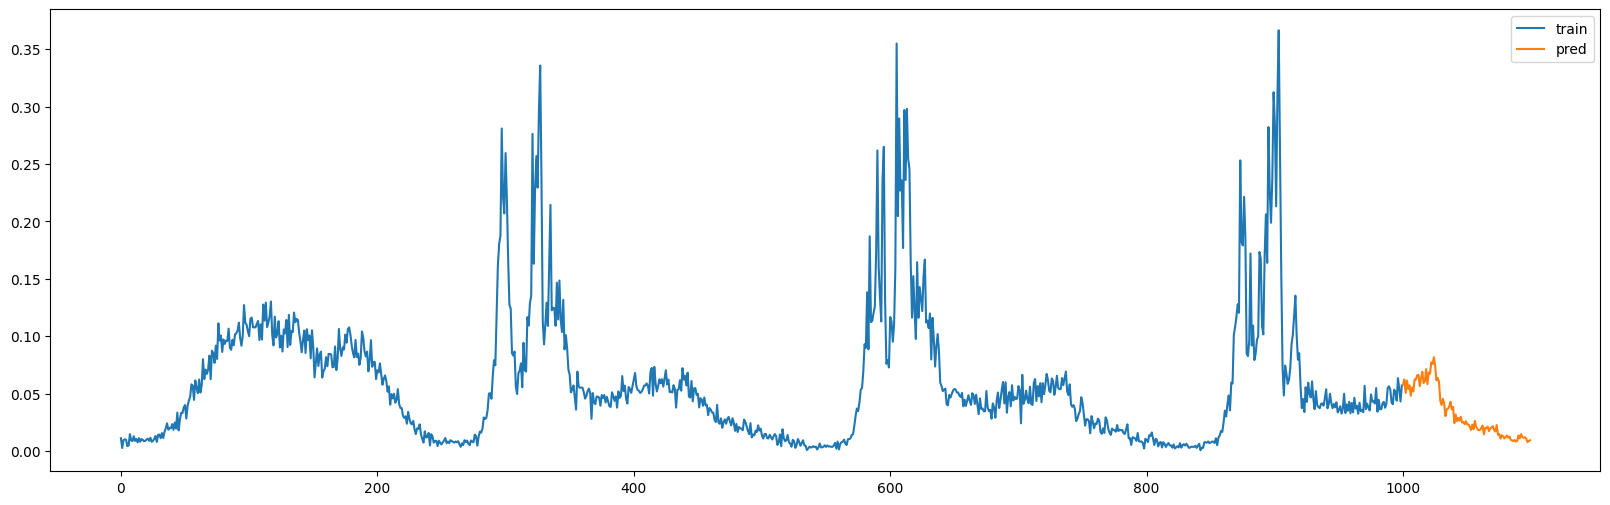

In [15]:
# нарисуем хвост из 1100 значений вместе с предсказанными
hue_col = ['train'] * 1000 + ['pred'] * 100

import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(x=np.arange(1100), y=tmp_table.iloc[10, -1100:].values, hue=hue_col, n_boot=0)
plt.gcf().set_size_inches(20, 6)

# [110, 183, 184, 185, 209, 251, 281]
# [14.297593375389518,
#  0.5053909933412297,
#  0.0004363455359933018,
#  46.001497073594365,
#  19.80514654660157,
#  5.238317349567694,
#  12.29713445953481]

## Solution for 2nd baseline

### Используем градиентый бустинг для предсказания

In [16]:
tmp_table2 = X.iloc[:, :-1].copy() 
weights = calculate_weights(tmp_table2)
table_true = X.iloc[:, -1:]

In [ ]:
# table_true

,tr_17755
row_id,
0_0,430.0000
0_1,0.1488
0_2,61.8000
100_0,291.0000
100_1,0.1079
...,...
99_1,0.0833
99_2,59.3000
9_0,744.0000


In [17]:
# tmp_table2

In [18]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 15.9 MB/s eta 0:00:00


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from catboost import CatBoost, CatBoostRegressor, Pool, CatBoostClassifier

cat = CatBoostRegressor(learning_rate=0.1, n_estimators=50, loss_function="Quantile:alpha=0.1")

In [20]:
# table_to_train = tmp_table2.iloc[:, -2304:-2016]
# table_true = tmp_table2.iloc[:, -2016]
# columns = [i for i in range(288)]
# table_to_train.columns = columns
# table_to_train

In [21]:
# cat.fit(table_to_train, table_true)

In [22]:
# table_true = X.iloc[:, -1:]
# tmp_table = tmp_table2.iloc[:, -288:]
# columns = [i for i in range(288)]
# tmp_table.columns = columns
# tmp_table

In [23]:
# table_true

In [24]:
# y_grad = cat.predict(tmp_table)

In [25]:
# table_to_add = tmp_table2.copy()
# table_to_add['pred_1'] = y_grad
# table_to_add

In [26]:
# X

In [27]:
# X.iloc[:, -100:].to_csv('output.csv', encoding = 'utf-8-sig') 
# files.download('output.csv')

Gradient boosting

In [28]:
# table_to_add = X.copy()

# for i in range(100):
#   table_to_train = table_to_add.iloc[:, -2304:-2016]
#   table_true = table_to_add.iloc[:, -2016]
#   columns = [i for i in range(288)]
#   table_to_train.columns = columns

#   cat.fit(table_to_train, table_true)

#   tmp_table = table_to_add.iloc[:, -288:]
#   tmp_table.columns = columns
#   y_grad = cat.predict(tmp_table)
#   table_to_add[f'pred_{i}'] = y_grad


In [29]:
# table_check = table_to_add.iloc[:, -100:].copy()
# table_check
# score_grad = []
# for i in range(510):
#   score_grad.append(calculate_mase(np.array(table_true.iloc[i]), np.array(table_check.iloc[i]), weights[i]))


In [30]:
# import seaborn as sns
# import pandas as pd

# # пример индекса и значений
# index = [i for i in range(510)]


# # создание DataFrame из индекса и значений
# df = pd.DataFrame({'score': score_grad}, index=index)

# # сортировка DataFrame по значению в порядке возрастания
# df_sorted = df.sort_values(by='score')

# # добавление столбца с индексом
# df_sorted['index'] = df_sorted.index

# # построение гистограммы с помощью seaborn.barplot()
# sns.set(rc={'figure.figsize':(20.7,8.27)})
# sns.barplot(x='index', y='score', data=df_sorted.iloc[:-500],  order=df_sorted.iloc[:-500]['index'])

In [31]:
# mask2 = (np.array(score_grad) < np.array(score))
# mask3 = (np.array(score_grad) < np.array(score_short_period))
# print(mask2 * mask3)

In [32]:
# print(y_grad)
# print(np.array(table_true))

#### Check quality on MASE

In [33]:
tmp_table2 = X.iloc[:, :-2016].copy() 
weights = calculate_weights(tmp_table2)
table_true = X.iloc[:, -2016:-1916]

In [35]:
table_true

,tr_15740,tr_15741,tr_15742,tr_15743,tr_15744,tr_15745,tr_15746,tr_15747,tr_15748,tr_15749,...,tr_15830,tr_15831,tr_15832,tr_15833,tr_15834,tr_15835,tr_15836,tr_15837,tr_15838,tr_15839
row_id,,,,,,,,,,,,,,,,,,,,,
0_0,446.0000,475.0000,461.0000,459.0000,435.0000,445.0000,509.0000,514.0000,498.0000,519.0000,...,148.0000,127.0000,121.0000,115.0000,111.0000,129.0000,130.0000,128.0000,121.0000,115.0000
0_1,0.1455,0.1500,0.1517,0.1612,0.1304,0.1425,0.1646,0.1538,0.1541,0.1550,...,0.0635,0.0612,0.0549,0.0546,0.0529,0.0622,0.0593,0.0671,0.0569,0.0571
0_2,63.1000,63.6000,63.6000,62.7000,65.1000,64.8000,64.1000,65.1000,64.3000,64.5000,...,68.9000,65.9000,66.5000,66.4000,64.6000,64.4000,64.9000,62.8000,62.9000,63.2000
100_0,294.0000,307.0000,323.0000,299.0000,293.0000,316.0000,292.0000,321.0000,292.0000,316.0000,...,124.0000,159.0000,133.0000,146.0000,128.0000,130.0000,121.0000,132.0000,124.0000,132.0000
100_1,0.0998,0.1332,0.1087,0.1224,0.1973,0.1800,0.2309,0.1967,0.2013,0.1440,...,0.0470,0.0589,0.0520,0.0526,0.0464,0.0477,0.0477,0.0514,0.0455,0.0473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99_1,0.1011,0.0942,0.0995,0.1006,0.0965,0.0939,0.0971,0.0934,0.0809,0.0844,...,0.0469,0.0561,0.0486,0.0474,0.0439,0.0451,0.0421,0.0462,0.0347,0.0397
99_2,56.6000,59.2000,59.8000,58.6000,57.9000,59.2000,60.4000,60.3000,60.5000,60.7000,...,65.3000,59.8000,60.5000,59.2000,60.7000,61.3000,63.8000,63.4000,64.1000,63.8000
9_0,633.0000,628.0000,611.0000,617.0000,676.0000,650.0000,651.0000,669.0000,682.0000,645.0000,...,248.0000,265.0000,222.0000,278.0000,218.0000,211.0000,203.0000,217.0000,189.0000,183.0000


In [36]:
# tmp_table2

Make predictions

In [37]:
tmp_table2 = X.iloc[:, :-2016].copy() 
weights = calculate_weights(tmp_table2)
table_true = X.iloc[:, -2016:-1916]

In [38]:
for i in range(100):
    tmp_table2.loc[:, f'pred_{i}'] = 0.63*tmp_table2.iloc[:, -2016]+ tmp_table2.iloc[:, -288] * 0.32 + tmp_table2.iloc[:, -1] * 0.03 + tmp_table2.iloc[:, -2] * 0.012 + tmp_table2.iloc[:, -3] * 0.008

table_pred = tmp_table2.iloc[:, -100:]


<ipython-input-38-586bda0fd27c>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tmp_table2.loc[:, f'pred_{i}'] = 0.63*tmp_table2.iloc[:, -2016]+ tmp_table2.iloc[:, -288] * 0.32 + tmp_table2.iloc[:, -1] * 0.03 + tmp_table2.iloc[:, -2] * 0.012 + tmp_table2.iloc[:, -3] * 0.008


In [39]:
# table_zeros1 = X.iloc[:, :-2016].copy()
# for i in range(100):
#   table_zeros1.loc[:, f'pred_{i}'] = table_zeros1.iloc[:, -2016]

<ipython-input-39-c349fccc07d8>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  table_zeros1.loc[:, f'pred_{i}'] = table_zeros1.iloc[:, -2016]


In [40]:
# mask_zeros = []
# for i in range(510):
#   if i in zero_indices:
#     mask_zeros.append(True)
#   else:
#     mask_zeros.append(False)
    

NameError: ignored

In [42]:
tmp_table2.loc[mask_zeros] = table_zeros1.loc[mask_zeros].values

In [43]:
table_pred = tmp_table2.iloc[:, -100:]

In [44]:
mask_first = []
for i in range(510):
  if i % 3 == 0:
    mask_first.append(True)
  else:
    mask_first.append(False)
# mask_first

In [ ]:
# tmp_table_first = X.iloc[:, :-2016].copy()
# for i in range(100):
#   tmp_table_first.loc[:, f'pred_{i}'] = tmp_table_first.iloc[:, -288] * 0.88 + tmp_table_first.iloc[:, -1] * 0.06 + tmp_table_first.iloc[:, -2] * 0.04 + tmp_table_first.iloc[:, -2] * 0.02

# tmp_table2.loc[mask_first] = tmp_table_first.loc[mask_first].values
# table_pred = tmp_table2.iloc[:, -100:]
# table_pred

In [45]:
# tmp_table2.iloc[:, -101:]

In [46]:
tmp_table2['pred_0'] = tmp_table2['tr_15739']
tmp_table2['pred_1'] = tmp_table2['tr_15739']*0.89 + 0.11*tmp_table2['pred_1']
tmp_table2['pred_2'] = 0.1 * tmp_table2['pred_1'] + 0.9 * tmp_table2['pred_2']
table_pred = tmp_table2.iloc[:, -100:]

In [47]:
tmp_table2.iloc[:, -101:]

,tr_15739,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,...,pred_90,pred_91,pred_92,pred_93,pred_94,pred_95,pred_96,pred_97,pred_98,pred_99
row_id,,,,,,,,,,,,,,,,,,,,,
0_0,484.0000,484.0000,482.162613,463.469679,451.233866,431.322100,464.195611,448.611604,433.649272,475.936382,...,133.264542,143.276882,161.522529,134.951115,136.643019,120.960884,123.828152,121.489519,117.838310,96.923649
0_1,0.1629,0.1629,0.161746,0.151960,0.147103,0.146874,0.154955,0.149301,0.142136,0.156188,...,0.062741,0.063621,0.073600,0.064180,0.065988,0.055389,0.056887,0.056387,0.054365,0.048998
0_2,62.1000,62.1000,62.148426,63.167546,62.926756,62.453494,61.783972,62.319375,63.277617,63.272433,...,64.785333,65.374500,64.174919,64.194024,62.879916,65.299125,65.203085,66.207721,65.972062,64.985279
100_0,284.0000,284.0000,283.650490,301.390611,323.557428,312.263645,318.497492,320.140548,311.454296,314.713295,...,143.458339,138.195658,143.763589,136.608922,137.028996,130.700286,136.478228,134.968982,129.362410,121.832326
100_1,0.0919,0.0919,0.093724,0.136904,0.151999,0.179338,0.178102,0.174380,0.224206,0.193865,...,0.050452,0.049612,0.051985,0.050667,0.049870,0.046853,0.051010,0.051491,0.051338,0.044950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99_1,0.0961,0.0961,0.095829,0.099556,0.098019,0.097716,0.092633,0.095552,0.087975,0.088222,...,0.051773,0.048701,0.045052,0.049664,0.043888,0.044773,0.044860,0.046257,0.043415,0.045507
99_2,58.0000,58.0000,58.250288,59.218789,58.463856,58.680035,58.321579,58.871519,59.553445,60.457634,...,62.298938,63.385255,62.402611,61.970093,61.042016,63.508122,63.150509,62.492949,63.683660,63.360629
9_0,697.0000,697.0000,697.232571,686.820803,678.362298,681.541750,709.941912,690.673657,655.471847,628.251775,...,275.612827,277.421724,284.998995,277.143933,222.243680,224.003030,215.184167,223.631511,192.593180,193.522847


In [48]:
score = []
for i in range(510):
  score.append(calculate_mase(np.array(table_true.iloc[i]), np.array(table_pred.iloc[i]), weights[i]))

<Axes: xlabel='index', ylabel='score'>

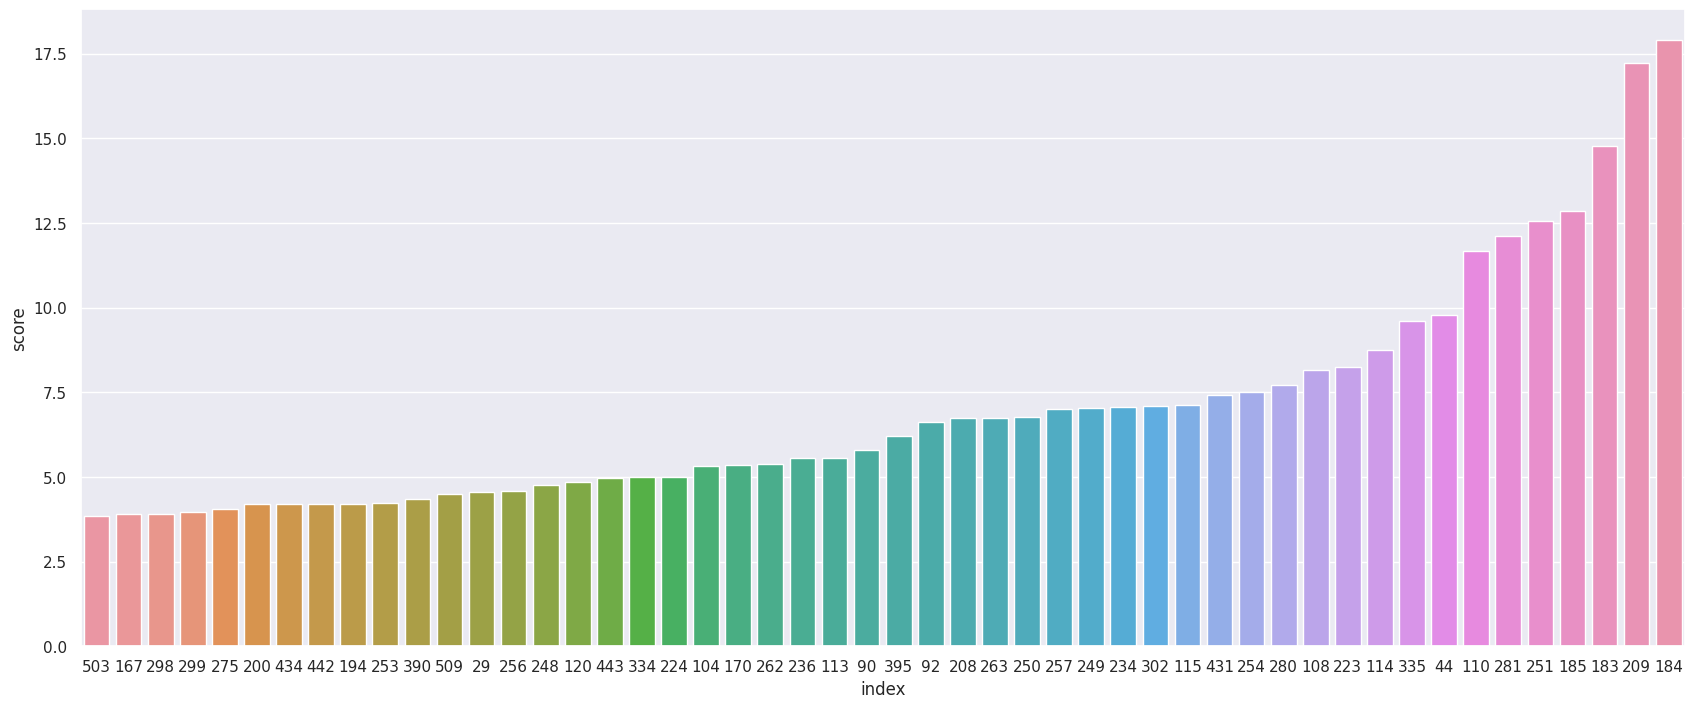

In [49]:
import seaborn as sns
import pandas as pd

# пример индекса и значений
index = [i for i in range(510)]


# создание DataFrame из индекса и значений
df = pd.DataFrame({'score': score}, index=index)

# сортировка DataFrame по значению в порядке возрастания
df_sorted = df.sort_values(by='score')

# добавление столбца с индексом
df_sorted['index'] = df_sorted.index

# построение гистограммы с помощью seaborn.barplot()
sns.set(rc={'figure.figsize':(20.7,8.27)})
sns.barplot(x='index', y='score', data=df_sorted.iloc[-50:],  order=df_sorted.iloc[-50:]['index'])

In [50]:
print(np.array(score).sum())

934.9176353221796


In [51]:
tmp_table2 = X.iloc[:, :-4032].copy() 
weights = calculate_weights(tmp_table2)
table_true = X.iloc[:, -4032:-3932]

for i in range(100):
    tmp_table2.loc[:, f'pred_{i}'] = tmp_table2.iloc[:, -2016]
table_pred = tmp_table2.iloc[:, -100:]
table_pred

score2 = []
for i in range(510):
  score2.append(calculate_mase(np.array(table_true.iloc[i]), np.array(table_pred.iloc[i]), weights[i]))

<ipython-input-51-d2f6fefea403>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tmp_table2.loc[:, f'pred_{i}'] = tmp_table2.iloc[:, -2016]


In [52]:
zero_indices2 = [index for index, value in enumerate(score2) if value == 0]
print(zero_indices2)  # [0, 3, 5, 7]

[30, 31, 32, 51, 52, 53, 54, 55, 56, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 99, 100, 101, 105, 106, 107, 138, 139, 140, 141, 142, 143, 147, 148, 149, 150, 151, 152, 162, 163, 164, 177, 178, 179, 195, 196, 197, 234, 235, 236, 270, 271, 272, 336, 337, 338, 345, 346, 347, 348, 349, 350, 360, 361, 362, 378, 379, 380, 381, 382, 383, 384, 385, 386, 390, 391, 392, 411, 412, 413, 420, 421, 422, 423, 424, 425, 426, 427, 428, 444, 445, 446, 447, 448, 449, 453, 454, 455, 456, 457, 458, 477, 478, 479, 480, 481, 482]


In [53]:
r = set([1, 2]) & set([2, 3])
r

{2}

In [54]:
zero_indices = set([i for i in range(510)])
for j in range(100):
  tmp_table2 = X.iloc[:, :-j-2016].copy() 
  weights = calculate_weights(tmp_table2)
  table_true = X.iloc[:, -j-2016:-j-1916]
  for i in range(100):
    tmp_table2.loc[:, f'pred_{i}'] = tmp_table2.iloc[:, -2016]
  table_pred = tmp_table2.iloc[:, -100:]
  table_pred
  score = []
  for i in range(510):
    score.append(calculate_mase(np.array(table_true.iloc[i]), np.array(table_pred.iloc[i]), weights[i]))
  zero = [index for index, value in enumerate(score) if value == 0]
  zero_indices = zero_indices & set(zero)

<ipython-input-54-344c76807924>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tmp_table2.loc[:, f'pred_{i}'] = tmp_table2.iloc[:, -2016]
<ipython-input-54-344c76807924>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tmp_table2.loc[:, f'pred_{i}'] = tmp_table2.iloc[:, -2016]
<ipython-input-54-344c76807924>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To

In [55]:
len(zero_indices)

111

In [56]:
tmp_table2 = X.iloc[:, :-2016].copy() 
weights = calculate_weights(tmp_table2)
table_true = X.iloc[:, -2016:-1916]

In [57]:
for i in range(100):
    tmp_table2.loc[:, f'pred_{i}'] = tmp_table2.iloc[:, -2016]
table_pred = tmp_table2.iloc[:, -100:]
table_pred

<ipython-input-57-bf88081d67c3>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tmp_table2.loc[:, f'pred_{i}'] = tmp_table2.iloc[:, -2016]


,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9,...,pred_90,pred_91,pred_92,pred_93,pred_94,pred_95,pred_96,pred_97,pred_98,pred_99
row_id,,,,,,,,,,,,,,,,,,,,,
0_0,476.0000,472.0000,446.0000,435.0000,429.0000,457.0000,450.0000,419.0000,473.0000,438.0000,...,142.0000,141.0000,176.0000,132.0000,137.0000,125.0000,124.0000,125.0000,122.0000,90.0000
0_1,0.1570,0.1512,0.1453,0.1398,0.1401,0.1543,0.1487,0.1409,0.1539,0.1397,...,0.0663,0.0666,0.0817,0.0637,0.0658,0.0558,0.0576,0.0592,0.0580,0.0453
0_2,61.7000,62.6000,63.6000,63.4000,63.0000,61.5000,62.7000,63.3000,63.6000,64.5000,...,65.1000,64.4000,62.8000,63.4000,62.7000,65.5000,64.8000,65.1000,64.7000,64.6000
100_0,310.0000,284.0000,312.0000,333.0000,317.0000,310.0000,327.0000,303.0000,310.0000,306.0000,...,146.0000,135.0000,145.0000,139.0000,142.0000,132.0000,138.0000,139.0000,121.0000,124.0000
100_1,0.0978,0.1175,0.1673,0.1794,0.1966,0.1852,0.1883,0.2421,0.1979,0.2039,...,0.0495,0.0491,0.0528,0.0500,0.0511,0.0467,0.0519,0.0537,0.0506,0.0464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99_1,0.0930,0.0914,0.1000,0.1005,0.0965,0.0946,0.0960,0.0849,0.0849,0.0831,...,0.0505,0.0512,0.0424,0.0526,0.0452,0.0444,0.0447,0.0457,0.0405,0.0453
99_2,60.1000,60.4000,59.2000,58.2000,58.8000,58.3000,59.4000,59.8000,61.4000,60.9000,...,63.0000,63.7000,63.7000,61.7000,60.1000,62.2000,62.3000,62.0000,64.1000,63.7000
9_0,687.0000,703.0000,674.0000,666.0000,671.0000,701.0000,695.0000,642.0000,602.0000,647.0000,...,291.0000,298.0000,315.0000,286.0000,227.0000,235.0000,218.0000,233.0000,185.0000,194.0000


Заметим, что есть ряды в которых периодичность 2016

In [58]:
score = []
for i in range(510):
  score.append(calculate_mase(np.array(table_true.iloc[i]), np.array(table_pred.iloc[i]), weights[i]))

In [59]:
score.count(0)

111

In [60]:
np.array(score)

array([ 1.20449335,  1.11707079,  1.93587097,  0.97782406,  1.84473457,
        2.08912443,  1.29215676,  1.31834452,  2.11665898,  1.39051968,
        1.22255655,  1.48743444,  1.2356957 ,  1.04390498,  1.74160054,
        1.06863529,  1.11400501,  2.21807984,  1.15101554,  1.18127112,
        1.39412914,  0.67256052,  0.61554371,  1.07385849,  1.08633579,
        1.59385207,  4.33721601,  3.46313689,  3.878391  ,  5.94359041,
        0.        ,  0.        ,  0.        ,  3.65266299,  1.85080489,
        2.70682095,  1.07707634,  1.07269858,  1.42446281,  1.09860246,
        1.05088494,  1.46541881,  0.43819484,  0.48183351,  8.02693567,
        0.62318001,  0.63950002,  1.59238492,  1.20217035,  1.20818136,
        2.402447  ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  1.0830105 ,  0.93166826,  1.85210245,
        1.21226944,  1.17279819,  1.98452626,  1.2103199 ,  1.28504118,
        2.53694307,  0.90897038,  1.06187225,  1.73477847,  1.40

In [61]:
zero_indices = [index for index, value in enumerate(score) if value == 0]
print(zero_indices)  # [0, 3, 5, 7]

[30, 31, 32, 51, 52, 53, 54, 55, 56, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 99, 100, 101, 105, 106, 107, 138, 139, 140, 141, 142, 143, 147, 148, 149, 150, 151, 152, 162, 163, 164, 177, 178, 179, 180, 181, 182, 195, 196, 197, 270, 271, 272, 336, 337, 338, 345, 346, 347, 348, 349, 350, 360, 361, 362, 378, 379, 380, 381, 382, 383, 384, 385, 386, 411, 412, 413, 420, 421, 422, 423, 424, 425, 426, 427, 428, 444, 445, 446, 447, 448, 449, 453, 454, 455, 456, 457, 458, 477, 478, 479, 480, 481, 482]


In [62]:
print(zero_indices)

[30, 31, 32, 51, 52, 53, 54, 55, 56, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 99, 100, 101, 105, 106, 107, 138, 139, 140, 141, 142, 143, 147, 148, 149, 150, 151, 152, 162, 163, 164, 177, 178, 179, 180, 181, 182, 195, 196, 197, 270, 271, 272, 336, 337, 338, 345, 346, 347, 348, 349, 350, 360, 361, 362, 378, 379, 380, 381, 382, 383, 384, 385, 386, 411, 412, 413, 420, 421, 422, 423, 424, 425, 426, 427, 428, 444, 445, 446, 447, 448, 449, 453, 454, 455, 456, 457, 458, 477, 478, 479, 480, 481, 482]


In [63]:
len(set(zero_indices) & set(zero_indices2))

108

In [64]:
score[30]

0.0

In [ ]:
# print(np.array(new_lst))

[ 31  52  55  70  73  76  79  85  88  91 106 112 115 118 121 124 127 139
 142 148 151 157 163 172 175 181 184 190 196 199 211 220 223 238 241 247
 250 253 262 274 277 280 337 346 349 361 379 382 385 403 412 421 424 427
 430 433 445 448 454 457 460 475 478 481 490]


Найдем ряды, в которых лежат малые значения

In [65]:
q = X.copy()
q.reset_index(drop=True)

,tr_0,tr_1,tr_2,tr_3,tr_4,tr_5,tr_6,tr_7,tr_8,tr_9,...,tr_17746,tr_17747,tr_17748,tr_17749,tr_17750,tr_17751,tr_17752,tr_17753,tr_17754,tr_17755
0,133.0000,114.0000,140.0000,106.0000,117.0000,110.0000,130.0000,112.0000,115.0000,93.0000,...,446.0000,468.0000,447.0000,443.0000,476.0000,509.0000,462.0000,412.0000,429.0000,430.0000
1,0.0603,0.0532,0.0622,0.0452,0.0574,0.0545,0.0566,0.0606,0.0479,0.0477,...,0.1498,0.1595,0.1527,0.1491,0.1554,0.1643,0.1621,0.1450,0.1480,0.1488
2,65.8000,66.9000,66.8000,68.9000,67.4000,65.5000,66.4000,63.0000,67.3000,65.7000,...,61.6000,61.7000,61.8000,62.5000,62.4000,62.7000,62.7000,62.5000,62.3000,61.8000
3,124.0000,125.0000,127.0000,121.0000,121.0000,132.0000,124.0000,116.0000,116.0000,118.0000,...,261.0000,281.0000,222.0000,254.0000,284.0000,286.0000,264.0000,281.0000,288.0000,291.0000
4,0.0493,0.0475,0.0486,0.0481,0.0478,0.0496,0.0446,0.0467,0.0443,0.0494,...,0.0873,0.0932,0.0763,0.0874,0.0970,0.0905,0.0824,0.0915,0.0985,0.1079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,0.0472,0.0425,0.0491,0.0449,0.0421,0.0526,0.0474,0.0495,0.0403,0.0504,...,0.0848,0.0901,0.0935,0.0825,0.0894,0.0941,0.0950,0.0864,0.0924,0.0833
506,64.1000,63.4000,62.2000,62.4000,64.3000,61.4000,61.1000,59.1000,61.0000,57.9000,...,58.4000,56.8000,58.0000,58.9000,57.8000,58.4000,57.3000,57.5000,57.0000,59.3000
507,256.0000,210.0000,224.0000,208.0000,188.0000,211.0000,178.0000,189.0000,169.0000,171.0000,...,670.0000,789.0000,769.0000,655.0000,690.0000,732.0000,684.0000,684.0000,724.0000,744.0000
508,0.0385,0.0337,0.0367,0.0324,0.0261,0.0319,0.0263,0.0278,0.0242,0.0276,...,0.1053,0.1353,0.2367,0.3538,0.2955,0.2729,0.2902,0.2838,0.2549,0.3091


In [66]:
def check_row(row):
    return sum((row < 0.1) & (row >= 0)) >= len(row)*0.5

search_small = X.copy()
search_small = search_small.reset_index(drop=True)
# mask_r = ((search_small < 0.1) & (search_small >= 0)).any(axis=1)
# rows = search_small[mask_r]
result = search_small.apply(check_row, axis=1)
search_small = search_small[result]
search_small.index
lst = search_small.index.to_list()
len(lst)

161

In [67]:
mask_first

[True,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 Fal

In [68]:
# X.iloc[::3, :]

In [69]:
# X.iloc[[5], :-2016]

In [ ]:
X.iloc[2::3, :-2016]

,tr_0,tr_1,tr_2,tr_3,tr_4,tr_5,tr_6,tr_7,tr_8,tr_9,...,tr_15730,tr_15731,tr_15732,tr_15733,tr_15734,tr_15735,tr_15736,tr_15737,tr_15738,tr_15739
row_id,,,,,,,,,,,,,,,,,,,,,
0_2,65.8,66.9,66.8,68.9,67.4,65.5,66.4,63.0,67.3,65.7,...,62.8,61.6,62.1,61.1,62.5,62.7,62.7,62.6,62.2,62.1
100_2,64.2,63.5,63.2,62.2,61.9,62.6,65.3,63.3,64.2,61.2,...,59.6,59.7,60.2,59.5,57.7,57.1,57.3,59.2,60.0,61.0
101_2,69.0,69.1,68.0,69.3,65.8,66.7,66.1,65.4,67.3,66.2,...,60.2,60.6,61.6,62.9,63.6,63.1,62.8,63.5,65.0,65.7
102_2,65.0,65.1,65.1,64.8,64.8,64.5,64.4,64.7,64.9,65.1,...,64.0,62.5,65.2,64.9,66.3,66.5,66.2,63.5,64.5,66.0
103_2,65.0,64.8,64.9,64.9,64.8,64.4,64.7,64.5,64.8,65.0,...,62.9,63.7,63.5,62.9,63.8,64.4,66.0,64.1,63.8,66.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96_2,64.1,63.9,64.1,64.0,63.9,64.0,63.9,64.1,64.1,63.9,...,62.8,62.9,62.6,61.8,62.4,62.7,63.0,62.6,62.6,62.5
97_2,68.7,67.6,68.4,66.1,64.7,65.3,66.3,67.0,67.5,67.1,...,64.4,65.2,64.3,64.3,64.7,63.7,62.4,63.3,64.4,65.1
98_2,69.2,68.0,68.1,67.5,67.6,68.1,68.7,68.0,67.8,67.7,...,67.3,66.4,65.7,64.9,66.5,65.8,68.0,68.0,68.9,69.3


In [ ]:
# table_to_grad = X.iloc[2::3, :-2016].copy()

# cat = CatBoostRegressor(learning_rate=0.1, n_estimators=350)

# for i in range(100):
#   table_to_train = table_to_grad.iloc[:, -2304:-2016]
#   table_true = table_to_grad.iloc[:, -2016]
#   columns = [i for i in range(288)]
#   table_to_train.columns = columns

#   cat.fit(table_to_train, table_true)

#   tmp_table = table_to_grad.iloc[:, -288:]
#   tmp_table.columns = columns
#   y_grad = cat.predict(tmp_table)
#   table_to_grad[f'pred_{i}'] = y_grad

Выходные данные были обрезаны до нескольких последних строк (5000).
250:	learn: 0.0538058	total: 7.6s	remaining: 3s
251:	learn: 0.0532416	total: 7.62s	remaining: 2.96s
252:	learn: 0.0527469	total: 7.64s	remaining: 2.93s
253:	learn: 0.0517498	total: 7.67s	remaining: 2.9s
254:	learn: 0.0507740	total: 7.69s	remaining: 2.87s
255:	learn: 0.0496685	total: 7.72s	remaining: 2.83s
256:	learn: 0.0484381	total: 7.74s	remaining: 2.8s
257:	learn: 0.0476933	total: 7.76s	remaining: 2.77s
258:	learn: 0.0469697	total: 7.79s	remaining: 2.74s
259:	learn: 0.0460909	total: 7.82s	remaining: 2.71s
260:	learn: 0.0453417	total: 7.84s	remaining: 2.67s
261:	learn: 0.0443023	total: 7.86s	remaining: 2.64s
262:	learn: 0.0438139	total: 7.89s	remaining: 2.61s
263:	learn: 0.0429353	total: 7.91s	remaining: 2.58s
264:	learn: 0.0420051	total: 7.93s	remaining: 2.54s
265:	learn: 0.0408156	total: 7.95s	remaining: 2.51s
266:	learn: 0.0401009	total: 7.98s	remaining: 2.48s
267:	learn: 0.0394191	total: 8.01s	remaining: 2.45s
26

<ipython-input-221-bb4efca42cd0>:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  table_to_grad[f'pred_{i}'] = y_grad


In [ ]:
# table_to_grad = X.iloc[::3, :-2016].copy()

# cat = CatBoostRegressor(learning_rate=0.1, n_estimators=350)

# for i in range(100):
#   table_to_train = table_to_grad.iloc[:, -2304:-2016]
#   table_true = table_to_grad.iloc[:, -2016]
#   columns = [i for i in range(288)]
#   table_to_train.columns = columns

#   cat.fit(table_to_train, table_true)

#   tmp_table = table_to_grad.iloc[:, -288:]
#   tmp_table.columns = columns
#   y_grad = cat.predict(tmp_table)
#   table_to_grad[f'pred_{i}'] = y_grad

Выходные данные были обрезаны до нескольких последних строк (5000).
250:	learn: 0.6247865	total: 9.18s	remaining: 3.62s
251:	learn: 0.6173719	total: 9.21s	remaining: 3.58s
252:	learn: 0.6098875	total: 9.24s	remaining: 3.54s
253:	learn: 0.6056865	total: 9.28s	remaining: 3.51s
254:	learn: 0.6034294	total: 9.31s	remaining: 3.47s
255:	learn: 0.5927542	total: 9.34s	remaining: 3.43s
256:	learn: 0.5836657	total: 9.37s	remaining: 3.39s
257:	learn: 0.5783236	total: 9.4s	remaining: 3.35s
258:	learn: 0.5718998	total: 9.43s	remaining: 3.31s
259:	learn: 0.5640595	total: 9.47s	remaining: 3.28s
260:	learn: 0.5564475	total: 9.5s	remaining: 3.24s
261:	learn: 0.5533967	total: 9.54s	remaining: 3.21s
262:	learn: 0.5398292	total: 9.57s	remaining: 3.17s
263:	learn: 0.5342694	total: 9.6s	remaining: 3.13s
264:	learn: 0.5273817	total: 9.64s	remaining: 3.09s
265:	learn: 0.5214990	total: 9.67s	remaining: 3.05s
266:	learn: 0.5179022	total: 9.7s	remaining: 3.02s
267:	learn: 0.5124648	total: 9.73s	remaining: 2.98s


<ipython-input-114-37e084038f78>:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  table_to_grad[f'pred_{i}'] = y_grad


In [70]:
# table_true = X.iloc[:, -2016:-1916]

In [ ]:
# lst[0]

4

In [ ]:
# np.array(table_true.iloc[lst[0]])

array([0.0998, 0.1332, 0.1087, 0.1224, 0.1973, 0.18  , 0.2309, 0.1967,
       0.2013, 0.144 , 0.083 , 0.1215, 0.1677, 0.1949, 0.1533, 0.1911,
       0.1752, 0.2069, 0.2046, 0.2081, 0.2132, 0.2024, 0.1946, 0.2326,
       0.1843, 0.2308, 0.2361, 0.1709, 0.2154, 0.1729, 0.1886, 0.1859,
       0.1704, 0.1835, 0.1566, 0.1249, 0.0872, 0.0878, 0.0784, 0.0763,
       0.0673, 0.0753, 0.0748, 0.069 , 0.0728, 0.0692, 0.0665, 0.063 ,
       0.0707, 0.0731, 0.0663, 0.0638, 0.0706, 0.068 , 0.069 , 0.0677,
       0.0708, 0.0695, 0.0635, 0.0652, 0.065 , 0.0688, 0.0671, 0.0671,
       0.0691, 0.0629, 0.0657, 0.0641, 0.0638, 0.0687, 0.0608, 0.0634,
       0.0711, 0.0643, 0.0603, 0.0601, 0.0564, 0.0586, 0.0666, 0.0563,
       0.0618, 0.0577, 0.0562, 0.0573, 0.0578, 0.0572, 0.0542, 0.0547,
       0.0593, 0.0551, 0.047 , 0.0589, 0.052 , 0.0526, 0.0464, 0.0477,
       0.0477, 0.0514, 0.0455, 0.0473])

In [71]:
# table_to_grad

In [72]:
# lst5 = [i for i in range(510)]
# lst5 = lst5[2::3]
# table_pred5 = table_to_grad.iloc[:, -100:]
# table_pred5
# table_pred5 = table_to_grad.iloc[:, -100:]

# score_grad = []
# for i in range(len(lst5)):
#   score_grad.append(calculate_mase(np.array(table_true.iloc[lst5[i]]), np.array(table_pred5.iloc[i]), weights[lst5[i]]))


# # '''
# # [1.3669197068968237,
# #  0.629553925202065,
# #  0.3753985232995965,
# #  0.35337352258036026,
# #  1.2109422086415185] 
 
# #  with 650 estimators
# # '''
# score_grad

In [74]:
# score_check = [score[i] for i in lst5]
# score_check

# print(np.array(score_grad) < np.array(score_check))
# print(np.sum(np.array(score_grad)))
# print(np.sum(np.array(score_check)))
# mask_grad_5 = np.array(score_grad) < np.array(score_check)

In [75]:
lst3 = [i for i in range(510)]
lst3 = lst3[::3]
# lst3

In [76]:
# table_true

In [77]:
# table_pred3 = table_to_grad.iloc[:, -100:]
# table_pred3

In [78]:
# table_true

In [79]:
# np.array(table_true.iloc[lst3[0]])

In [80]:
# table_pred3 = table_to_grad.iloc[:, -100:]

# score_grad = []
# for i in range(len(lst3)):
#   score_grad.append(calculate_mase(np.array(table_true.iloc[lst3[i]]), np.array(table_pred3.iloc[i]), weights[lst3[i]]))


# # '''
# # [1.3669197068968237,
# #  0.629553925202065,
# #  0.3753985232995965,
# #  0.35337352258036026,
# #  1.2109422086415185] 
 
# #  with 650 estimators
# # '''
# score_grad

In [81]:
ar = [1, 2]
score_check = [score[i] for i in lst3]
score_check

[1.2044933501031807,
 0.9778240562260908,
 1.2921567602741806,
 1.3905196814946117,
 1.235695698984871,
 1.0686352886233137,
 1.1510155365841659,
 0.6725605249705277,
 1.0863357862657026,
 3.463136886333481,
 0.0,
 3.6526629937999697,
 1.0770763389686506,
 1.0986024601941087,
 0.4381948425187626,
 0.6231800094154958,
 1.2021703471160123,
 0.0,
 0.0,
 1.083010495772593,
 1.21226944180048,
 1.2103199015687478,
 0.9089703763317236,
 1.4055296721896446,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 8.964465851164883,
 0.8809874866961286,
 1.1157676092679898,
 0.0,
 1.0769927651547497,
 0.0,
 12.88067441577245,
 3.867395740584098,
 13.492501231352929,
 3.862944217938178,
 7.367035523753069,
 1.6877540785285587,
 4.613095117956889,
 1.049926254655996,
 1.0452092045012293,
 1.3456396453451551,
 0.0,
 0.0,
 2.3675891646171876,
 0.0,
 0.0,
 1.2387469075001507,
 1.611693472624103,
 1.2614322523702417,
 0.0,
 1.2539823594567732,
 1.1322165133649391,
 1.348088985726263,
 0.9480385636101354,
 0.0,
 0.0,
 22

In [82]:
# print(np.array(score_grad) < np.array(score_check))
# print(np.sum(np.array(score_grad)))
# print(np.sum(np.array(score_check)))

In [83]:
# mask_grad_3 = np.array(score_grad) < np.array(score_check)
# mask_grad_3

In [84]:
# mask_grad = np.array(score_grad) < np.array(score_check)
# mask_grad

In [85]:
# new_lst = []
# for i in range(len(lst)):
#   if mask_grad[i]:
#     new_lst.append(lst[i])

In [86]:
# print(len(new_lst))

In [87]:
# print(np.sum(np.array(score_grad)))
# print(np.sum(np.array(score_check)))

In [88]:
# lst = df_sorted.iloc[-7:]['index'].to_list().copy()
# lst.sort()
# print(lst)
# table_to_grad = X.iloc[lst, :].copy()
# table_to_grad
# cat = CatBoostRegressor(learning_rate=0.1, n_estimators=650, loss_function="Quantile:alpha=0.1")


# for i in range(100):
#   table_to_train = table_to_grad.iloc[:, -2304:-2016]
#   table_true = table_to_grad.iloc[:, -2016]
#   columns = [i for i in range(288)]
#   table_to_train.columns = columns

#   cat.fit(table_to_train, table_true)

#   tmp_table = table_to_grad.iloc[:, -288:]
#   tmp_table.columns = columns
#   y_grad = cat.predict(tmp_table)
#   table_to_grad[f'pred_{i}'] = y_grad

In [89]:
# print(lst)
# table_to_grad

In [90]:
# table_pred3 = table_to_grad.iloc[:, -100:]
# np.array(table_true.iloc[lst[0]])

In [91]:
# score_grad = []
# for i in range(7):
#   score_grad.append(calculate_mase(np.array(table_true.iloc[lst[i]]), np.array(table_pred3.iloc[i]), weights[lst[i]]))

In [92]:
# print(lst)
# score_grad

Полная ошибка:

In [93]:
print(np.sum(df_sorted['score'].to_list()))

934.9176353221796


Нашли ряды для дальнейшего исследования

Есть идея, что 3 датчик даёт в среднем бОльшие ошибки

In [94]:
tmp_table2 = X.iloc[:, :-2016].copy() 
weights = calculate_weights(tmp_table2)
table_true = X.iloc[:, -2016:-1916]

for i in range(100):
    tmp_table2.loc[:, f'pred_{i}'] = tmp_table2.iloc[:, -288] * 0.8 + tmp_table2.iloc[:, -1] * 0.15 + tmp_table2.iloc[:, -2] * 0.05

table_pred = tmp_table2.iloc[:, -100:]
table_pred

<ipython-input-94-d7f43deb534a>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tmp_table2.loc[:, f'pred_{i}'] = tmp_table2.iloc[:, -288] * 0.8 + tmp_table2.iloc[:, -1] * 0.15 + tmp_table2.iloc[:, -2] * 0.05


,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9,...,pred_90,pred_91,pred_92,pred_93,pred_94,pred_95,pred_96,pred_97,pred_98,pred_99
row_id,,,,,,,,,,,,,,,,,,,,,
0_0,479.000000,461.650000,485.197500,480.662125,441.959194,475.926985,449.487007,459.219400,480.957260,502.304559,...,117.408731,142.624873,136.064168,137.940869,135.494339,115.221194,122.457896,115.329744,110.622356,107.959841
0_1,0.155660,0.154694,0.159947,0.160287,0.159960,0.157928,0.151767,0.145302,0.159224,0.155389,...,0.056586,0.057731,0.058849,0.063154,0.065456,0.055216,0.055635,0.051586,0.048040,0.054025
0_2,62.425000,62.468750,62.731562,62.133172,61.496554,62.091142,61.668499,63.074832,62.704650,63.679439,...,64.074157,66.657439,66.562324,65.877220,63.609699,64.995316,65.809782,68.001233,68.290674,66.123663
100_0,288.750000,275.112500,286.904375,303.991281,302.343911,329.351151,310.119868,324.585538,323.393824,318.338350,...,138.956304,142.984634,141.995510,133.248558,128.687059,127.565487,132.769176,127.893651,141.822506,120.468058
100_1,0.098130,0.093395,0.096756,0.100783,0.140835,0.158884,0.148474,0.187415,0.182896,0.181045,...,0.051971,0.050717,0.050766,0.051671,0.048129,0.047083,0.049229,0.047658,0.051930,0.043052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99_1,0.097505,0.097671,0.100166,0.094468,0.099259,0.089932,0.094293,0.092961,0.094179,0.089255,...,0.053245,0.045105,0.049108,0.045061,0.041695,0.044827,0.044889,0.047055,0.048343,0.046484
99_2,59.305000,59.955750,59.558612,58.971579,58.543668,58.370129,58.002703,58.978912,58.786972,58.806991,...,61.394876,62.714356,60.236897,62.091252,62.485533,65.597393,64.883886,63.732452,63.204062,62.827232
9_0,689.500000,693.475000,704.096250,701.088188,701.968041,725.949615,688.790844,680.416107,674.901958,687.256099,...,248.374396,239.312775,229.915636,253.652984,212.743729,203.794209,206.806318,206.010658,203.641915,193.646820


In [95]:
score_short_period = []
for i in range(510):
  score_short_period.append(calculate_mase(np.array(table_true.iloc[i]), np.array(table_pred.iloc[i]), weights[i]))

Сравниваем ршения с большим учетом малого и большего периодов

In [96]:
print(score)
print(score_short_period)

[1.2044933501031807, 1.1170707899587127, 1.9358709689684226, 0.9778240562260908, 1.8447345663280088, 2.0891244326358906, 1.2921567602741806, 1.3183445247818617, 2.11665897636344, 1.3905196814946117, 1.2225565546141666, 1.487434437335987, 1.235695698984871, 1.0439049757406835, 1.7416005351082184, 1.0686352886233137, 1.1140050076307257, 2.2180798438355525, 1.1510155365841659, 1.181271121972842, 1.3941291414016612, 0.6725605249705277, 0.615543713891391, 1.073858490984006, 1.0863357862657026, 1.593852066874885, 4.337216005390946, 3.463136886333481, 3.8783910016672807, 5.943590405418741, 0.0, 0.0, 0.0, 3.6526629937999697, 1.8508048920676332, 2.706820952971415, 1.0770763389686506, 1.0726985830491003, 1.4244628126774215, 1.0986024601941087, 1.0508849448333137, 1.4654188095708007, 0.4381948425187626, 0.4818335054923966, 8.026935667467693, 0.6231800094154958, 0.6395000151805597, 1.5923849224201458, 1.2021703471160123, 1.208181362134799, 2.4024469972161873, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.083010

In [97]:
mask = np.array(score_short_period) < np.array(score)

### Попробуем бустинг (бустинг ко всем значеням даёт плохой результат)

In [ ]:
# tmp_table2 = X.iloc[:, :-2016].copy()

In [ ]:
# cat = CatBoostRegressor(learning_rate=0.1, n_estimators=750)

# table_to_train = tmp_table2.iloc[184, -2306:-2016] 
# table_true = tmp_table2.iloc[[184], -2016]
# columns = [i for i in range(290)]
# table_to_train.columns = columns

In [ ]:
# table_to_train = table_to_train.reset_index(drop=True)
# np.array(table_to_train).reshape(-1, 1)

In [ ]:
# table_to_train.values

In [ ]:
# # table_true = table_true.reset_index(drop=True)
# table_true.values.reshape(1,)

In [ ]:
# cat.fit(table_to_train.values.reshape(1, -1), table_true.values.reshape(1,))


Кажется 7 худших по качеству рядов больше зависят от периодичности 288

In [98]:
a = []
for i in range(100):
    a.append(tmp_table2.iloc[509, -388 + i] * 0.80 + tmp_table2.iloc[509, -101 + i] * 0.15 + tmp_table2.iloc[509, -102 + i] * 0.05)
# print(np.array(table_true.iloc[209]))
# print(np.array(table_pred.iloc[209]))
print(a)
print(calculate_mase(np.array(table_true.iloc[509]), np.array(a), weights[509]))

#443

[24.939999999999998, 25.041, 26.043150000000004, 27.638522500000004, 28.407935875, 27.88311650625, 27.7628642696875, 27.718585465765624, 26.82593103334922, 25.009818928290663, 24.532769390911064, 26.210406355051195, 25.718199422803234, 25.888250231173043, 27.72914750581612, 29.053784637431068, 30.94452507090547, 32.17436799250738, 31.573381452421383, 31.704725617488577, 32.894377915244355, 32.919392968161084, 32.74262784098639, 32.07736382455601, 30.928735965732724, 31.12317858608771, 33.3349135861998, 33.43639596723436, 33.96220507439514, 34.76615055952099, 34.913032837647904, 35.375262453623236, 36.09194100992588, 35.42255427417005, 35.4379801916218, 34.68682474245177, 31.85492272094886, 32.27257964526492, 30.67363308283718, 29.89467394468883, 30.737882745845184, 29.38541610911122, 27.144706553658942, 29.0609767885044, 30.916381845958607, 30.010506116319014, 31.487395009745782, 32.62363455727782, 39.10791493407896, 38.93736896797573, 42.19600109190031, 42.196268612183836, 45.95924034

In [99]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.5 MB/s eta 0:00:00


In [100]:
!pip install --upgrade statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [101]:
print(calculate_mase(np.array(table_true.iloc[1]), np.array(table_pred.iloc[1]), weights[1]))
print(table_pred.iloc[1])

0.8944237391621032
pred_0     0.155660
pred_1     0.154694
pred_2     0.159947
pred_3     0.160287
pred_4     0.159960
             ...   
pred_95    0.055216
pred_96    0.055635
pred_97    0.051586
pred_98    0.048040
pred_99    0.054025
Name: 0_1, Length: 100, dtype: float64


In [102]:
print(tmp_table2.iloc[1])

tr_0       0.060300
tr_1       0.053200
tr_2       0.062200
tr_3       0.045200
tr_4       0.057400
             ...   
pred_95    0.055216
pred_96    0.055635
pred_97    0.051586
pred_98    0.048040
pred_99    0.054025
Name: 0_1, Length: 15840, dtype: float64


ARIMA очень плохо себя показывает, HoltWinters тоже не дает хорошего прироста, кажется что никакая из этих библиотек не даёт особого выигрыша в качестве 

In [103]:
# from statsmodels.tsa.arima_model import ARIMA
# from pmdarima.arima import auto_arima
# import statsmodels.api as sm
# from statsmodels.tsa.arima_model import ARIMA
# from statsmodels.tsa.holtwinters import ExponentialSmoothing
# # from statsmodels.tsa.api import SeasonalNaive


# # model = auto_arima(tmp_table2.iloc[251], seasonal=True, m=2)
# # model = ExponentialSmoothing(tmp_table2.iloc[251], seasonal_periods=10, trend='add', seasonal='add')
# # model = ARIMA(tmp_table2.iloc[209, 13000:], order=(1, 1, 1))
# # model = sm.seasonal_naive.SN(tmp_table2.iloc[251], seasonal_periods=7)

In [104]:
# fitted_model = model.fit()
# forecast = fitted_model.forecast(100)

# forecast = model.predict(n_periods=100)

np.array(forecast)

In [ ]:
# np.array(forecast)

In [ ]:
# print(calculate_mase(np.array(table_true.iloc[251]), np.array(forecast), weights[251]))
# print(score_short_period[251])

Кажется качетсво хорошо улучшилось, возможно стоит применять эту модель для маленьких значений


## Применим предположения к нашему ответу

In [105]:
# lst = df_sorted.iloc[-30:]['index'].to_list().copy()
# lst.sort()
# print(lst)
tmp_table = X.copy()
save_id = tmp_table.index
tmp_table = tmp_table.reset_index(drop=True)
# mask = tmp_table.index.isin(lst)
# mask = (tmp_table.index == 110) | (tmp_table.index == 184) | (tmp_table.index == 183) | (tmp_table.index == 185) | (tmp_table.index == 209)\
# | (tmp_table.index == 251) | (tmp_table.index == 281)
# mask

In [106]:
# lst = df_sorted.iloc[-7:]['index'].to_list()
# tmp_table = X.copy()
# mask = (tmp_table.index == '0_0')
# tmp_table.iloc[0:]

In [107]:
tmp_table

,tr_0,tr_1,tr_2,tr_3,tr_4,tr_5,tr_6,tr_7,tr_8,tr_9,...,tr_17746,tr_17747,tr_17748,tr_17749,tr_17750,tr_17751,tr_17752,tr_17753,tr_17754,tr_17755
0,133.0000,114.0000,140.0000,106.0000,117.0000,110.0000,130.0000,112.0000,115.0000,93.0000,...,446.0000,468.0000,447.0000,443.0000,476.0000,509.0000,462.0000,412.0000,429.0000,430.0000
1,0.0603,0.0532,0.0622,0.0452,0.0574,0.0545,0.0566,0.0606,0.0479,0.0477,...,0.1498,0.1595,0.1527,0.1491,0.1554,0.1643,0.1621,0.1450,0.1480,0.1488
2,65.8000,66.9000,66.8000,68.9000,67.4000,65.5000,66.4000,63.0000,67.3000,65.7000,...,61.6000,61.7000,61.8000,62.5000,62.4000,62.7000,62.7000,62.5000,62.3000,61.8000
3,124.0000,125.0000,127.0000,121.0000,121.0000,132.0000,124.0000,116.0000,116.0000,118.0000,...,261.0000,281.0000,222.0000,254.0000,284.0000,286.0000,264.0000,281.0000,288.0000,291.0000
4,0.0493,0.0475,0.0486,0.0481,0.0478,0.0496,0.0446,0.0467,0.0443,0.0494,...,0.0873,0.0932,0.0763,0.0874,0.0970,0.0905,0.0824,0.0915,0.0985,0.1079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,0.0472,0.0425,0.0491,0.0449,0.0421,0.0526,0.0474,0.0495,0.0403,0.0504,...,0.0848,0.0901,0.0935,0.0825,0.0894,0.0941,0.0950,0.0864,0.0924,0.0833
506,64.1000,63.4000,62.2000,62.4000,64.3000,61.4000,61.1000,59.1000,61.0000,57.9000,...,58.4000,56.8000,58.0000,58.9000,57.8000,58.4000,57.3000,57.5000,57.0000,59.3000
507,256.0000,210.0000,224.0000,208.0000,188.0000,211.0000,178.0000,189.0000,169.0000,171.0000,...,670.0000,789.0000,769.0000,655.0000,690.0000,732.0000,684.0000,684.0000,724.0000,744.0000
508,0.0385,0.0337,0.0367,0.0324,0.0261,0.0319,0.0263,0.0278,0.0242,0.0276,...,0.1053,0.1353,0.2367,0.3538,0.2955,0.2729,0.2902,0.2838,0.2549,0.3091


In [108]:
print(np.array(lst))

[  4   7  10  13  16  19  22  25  28  31  34  37  40  43  46  49  52  55
  58  61  64  67  70  73  76  79  82  85  88  91  94  97 100 103 106 109
 112 115 118 121 124 127 130 136 139 142 145 148 151 154 157 160 163 166
 169 172 175 178 181 184 187 190 193 196 199 202 205 208 211 214 217 220
 223 226 229 232 235 238 241 247 250 253 259 262 268 271 274 277 280 283
 286 289 292 295 298 301 304 307 313 316 319 322 325 328 331 334 337 340
 346 349 352 355 358 361 364 367 370 373 376 379 382 385 388 391 394 397
 400 403 406 412 415 418 421 424 427 430 433 436 439 445 448 451 454 457
 460 463 466 469 472 475 478 481 484 487 490 493 496 499 502 505 508]


In [109]:
table_to_grad5 = X.iloc[2::3, :].copy()

cat = CatBoostRegressor(learning_rate=0.1, n_estimators=600)

for i in range(100):
  table_to_train = table_to_grad5.iloc[:, -2304:-2016]
  table_true = table_to_grad5.iloc[:, -2016]
  columns = [i for i in range(288)]
  table_to_train.columns = columns

  cat.fit(table_to_train, table_true)

  tmp_table = table_to_grad5.iloc[:, -288:]
  tmp_table.columns = columns
  y_grad = cat.predict(tmp_table)
  table_to_grad5[f'pred_{i}'] = y_grad

0:	learn: 8.1518552	total: 90.1ms	remaining: 54s
1:	learn: 7.7151061	total: 118ms	remaining: 35.4s
2:	learn: 7.3653450	total: 148ms	remaining: 29.4s
3:	learn: 7.0767905	total: 177ms	remaining: 26.4s
4:	learn: 6.6530671	total: 207ms	remaining: 24.6s
5:	learn: 6.4074791	total: 231ms	remaining: 22.9s
6:	learn: 6.1375888	total: 262ms	remaining: 22.2s
7:	learn: 5.9071324	total: 288ms	remaining: 21.3s
8:	learn: 5.6586467	total: 321ms	remaining: 21.1s
9:	learn: 5.4259200	total: 348ms	remaining: 20.5s
10:	learn: 5.1725856	total: 375ms	remaining: 20.1s
11:	learn: 4.9050885	total: 402ms	remaining: 19.7s
12:	learn: 4.6718996	total: 450ms	remaining: 20.3s
13:	learn: 4.4643800	total: 489ms	remaining: 20.5s
14:	learn: 4.2340699	total: 525ms	remaining: 20.5s
15:	learn: 4.0902520	total: 559ms	remaining: 20.4s
16:	learn: 3.9198785	total: 598ms	remaining: 20.5s
17:	learn: 3.7380174	total: 631ms	remaining: 20.4s
18:	learn: 3.6066215	total: 656ms	remaining: 20.1s
19:	learn: 3.4906219	total: 680ms	remainin

KeyboardInterrupt: ignored

In [110]:
table_to_grad3 = X.iloc[::3, :].copy()

cat = CatBoostRegressor(learning_rate=0.1, n_estimators=350)

for i in range(100):
  table_to_train = table_to_grad3.iloc[:, -2304:-2016]
  table_true = table_to_grad3.iloc[:, -2016]
  columns = [i for i in range(288)]
  table_to_train.columns = columns

  cat.fit(table_to_train, table_true)

  tmp_table = table_to_grad3.iloc[:, -288:]
  tmp_table.columns = columns
  y_grad = cat.predict(tmp_table)
  table_to_grad3[f'pred_{i}'] = y_grad

0:	learn: 133.8754746	total: 46ms	remaining: 16.1s
1:	learn: 124.2341910	total: 77.1ms	remaining: 13.4s
2:	learn: 115.9832473	total: 108ms	remaining: 12.5s
3:	learn: 107.8188110	total: 141ms	remaining: 12.2s
4:	learn: 100.0137406	total: 171ms	remaining: 11.8s
5:	learn: 93.3136625	total: 202ms	remaining: 11.6s
6:	learn: 87.1623749	total: 239ms	remaining: 11.7s
7:	learn: 81.5802055	total: 277ms	remaining: 11.8s
8:	learn: 76.3584895	total: 308ms	remaining: 11.7s
9:	learn: 71.3444768	total: 341ms	remaining: 11.6s
10:	learn: 66.8732062	total: 375ms	remaining: 11.5s
11:	learn: 62.7675746	total: 405ms	remaining: 11.4s
12:	learn: 59.0328079	total: 436ms	remaining: 11.3s
13:	learn: 55.9571729	total: 467ms	remaining: 11.2s
14:	learn: 52.8358063	total: 502ms	remaining: 11.2s
15:	learn: 50.0212001	total: 533ms	remaining: 11.1s
16:	learn: 47.3925092	total: 564ms	remaining: 11.1s
17:	learn: 44.8597152	total: 602ms	remaining: 11.1s
18:	learn: 42.8003432	total: 633ms	remaining: 11s
19:	learn: 40.81834

KeyboardInterrupt: ignored

In [111]:
table_to_grad2 = X.iloc[lst, :].copy()

cat = CatBoostRegressor(learning_rate=0.1, n_estimators=250, loss_function="Quantile:alpha=0.1")

for i in range(100):
  table_to_train = table_to_grad2.iloc[:, -2304:-2016]
  table_true = table_to_grad2.iloc[:, -2016]
  columns = [i for i in range(288)]
  table_to_train.columns = columns

  cat.fit(table_to_train, table_true)

  tmp_table = table_to_grad2.iloc[:, -288:]
  tmp_table.columns = columns
  y_grad = cat.predict(tmp_table)
  table_to_grad2[f'pred_{i}'] = y_grad

0:	learn: 0.0056419	total: 43.1ms	remaining: 10.7s
1:	learn: 0.0052818	total: 75.3ms	remaining: 9.34s
2:	learn: 0.0050169	total: 106ms	remaining: 8.72s
3:	learn: 0.0047973	total: 136ms	remaining: 8.36s
4:	learn: 0.0045306	total: 167ms	remaining: 8.19s
5:	learn: 0.0043397	total: 199ms	remaining: 8.08s
6:	learn: 0.0041247	total: 232ms	remaining: 8.04s
7:	learn: 0.0039428	total: 267ms	remaining: 8.08s
8:	learn: 0.0037443	total: 299ms	remaining: 8.02s
9:	learn: 0.0036046	total: 331ms	remaining: 7.95s
10:	learn: 0.0035067	total: 364ms	remaining: 7.91s
11:	learn: 0.0033523	total: 395ms	remaining: 7.84s
12:	learn: 0.0032627	total: 428ms	remaining: 7.8s
13:	learn: 0.0031013	total: 459ms	remaining: 7.74s
14:	learn: 0.0029762	total: 494ms	remaining: 7.74s
15:	learn: 0.0028575	total: 526ms	remaining: 7.69s
16:	learn: 0.0027800	total: 570ms	remaining: 7.82s
17:	learn: 0.0026561	total: 601ms	remaining: 7.75s
18:	learn: 0.0026111	total: 633ms	remaining: 7.7s
19:	learn: 0.0024917	total: 665ms	remaini

KeyboardInterrupt: ignored

In [112]:
# tmp_table = X.copy()
# tmp_table_first = X.copy()

# for i in range(100):
#     tmp_table.loc[:, f'pred_{i}'] = 0.90*tmp_table.iloc[:, -2016] + tmp_table.iloc[:, -1] * 0.07 + tmp_table.iloc[:, -2] * 0.03

# tmp_table

# mask_first = []
# for i in range(510):
#   if i % 3 == 0:
#     mask_first.append(True)
#   else:
#     mask_first.append(False)


# for i in range(100):
#   tmp_table_first.loc[:, f'pred_{i}'] = tmp_table_first.iloc[:, -288] * 0.88 + tmp_table_first.iloc[:, -1] * 0.06 + tmp_table_first.iloc[:, -2] * 0.04 + tmp_table_first.iloc[:, -2] * 0.02

# tmp_table_first
# tmp_table.loc[mask_first] = tmp_table_first.loc[mask_first].values
# table_pred = tmp_table.iloc[:, -100:]
# # table_pred.iloc[110] = a
# table_pred

In [113]:
# lst = df_sorted.iloc[-7:]['index'].to_list()
tmp_table = X.copy()
tmp_table = tmp_table.reset_index(drop=True)

# tmp_table.iloc[mask, -1] = tmp_table.iloc[mask, -288] * 0.95 + tmp_table.iloc[mask, -1] * 0.03 + tmp_table.iloc[mask, -2] * 0.02
for i in range(100):
  tmp_table.loc[:, f'pred_{i}'] = 0.63*tmp_table.iloc[:, -2016] + tmp_table.iloc[:, -288] * 0.32 + tmp_table.iloc[:, -1] * 0.03 \
  + tmp_table.iloc[:, -2] * 0.02
  tmp_table.loc[mask, f'pred_{i}'] = tmp_table.iloc[mask, -289] * 0.8 + tmp_table.iloc[mask, -2] * 0.15 + tmp_table.iloc[mask, -3] * 0.05
tmp_table = tmp_table.set_index(save_id)
table_pred = tmp_table.iloc[:, -100:]
# table_pred.iloc[110] = a
table_pred

<ipython-input-113-8718a88d3f0a>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tmp_table.loc[:, f'pred_{i}'] = 0.63*tmp_table.iloc[:, -2016] + tmp_table.iloc[:, -288] * 0.32 + tmp_table.iloc[:, -1] * 0.03 \


,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9,...,pred_90,pred_91,pred_92,pred_93,pred_94,pred_95,pred_96,pred_97,pred_98,pred_99
row_id,,,,,,,,,,,,,,,,,,,,,
0_0,500.350000,447.752500,492.180375,507.414681,475.121221,488.638917,471.451899,510.349731,467.325055,482.816245,...,132.781485,141.862268,139.918414,146.480876,132.968052,108.869252,121.378790,105.250281,120.256482,104.900986
0_1,0.169000,0.161670,0.162781,0.154421,0.153222,0.155984,0.150179,0.156726,0.140378,0.152333,...,0.058007,0.064050,0.065228,0.066427,0.057385,0.056249,0.056907,0.052068,0.056576,0.051170
0_2,61.905000,60.935750,61.435613,63.302129,63.287100,63.138171,63.355081,64.100171,64.862780,64.134425,...,66.125778,64.153197,62.849269,62.795050,64.481721,63.532011,64.273888,64.657684,63.552347,64.045736
100_0,297.250000,267.937500,279.853125,277.774844,280.458883,292.757575,313.136580,312.008366,310.458084,310.169131,...,150.200280,152.032402,135.914874,136.788851,128.914071,146.176553,131.572187,119.844656,129.355308,124.595529
100_1,0.098865,0.115824,0.104525,0.115076,0.158706,0.152047,0.183827,0.168637,0.189251,0.157498,...,0.049364,0.058072,0.050497,0.052614,0.047916,0.051805,0.047699,0.048609,0.047461,0.047299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99_1,0.095755,0.098208,0.099279,0.105162,0.091938,0.084009,0.081758,0.087904,0.087754,0.088918,...,0.044678,0.045736,0.049654,0.049175,0.047459,0.043418,0.045126,0.044780,0.043853,0.047377
99_2,57.425000,58.732750,58.952483,58.229229,58.634927,59.803632,60.890808,60.467797,60.410850,60.622681,...,65.004229,61.384233,60.712612,59.257063,60.656964,61.335850,62.671215,63.112853,63.657810,62.565991
9_0,714.200000,711.530000,711.239500,719.862425,705.941339,718.684322,671.099715,674.199173,673.884862,681.992688,...,252.575810,241.486436,232.051756,250.082085,210.714901,195.311339,198.232446,203.500434,206.036687,185.880525


In [114]:
print(zero_indices)
table_zeros = X.copy()
for i in range(100):
  table_zeros.loc[:, f'pred_{i}'] = table_zeros.iloc[:, -2016]


[30, 31, 32, 51, 52, 53, 54, 55, 56, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 99, 100, 101, 105, 106, 107, 138, 139, 140, 141, 142, 143, 147, 148, 149, 150, 151, 152, 162, 163, 164, 177, 178, 179, 180, 181, 182, 195, 196, 197, 270, 271, 272, 336, 337, 338, 345, 346, 347, 348, 349, 350, 360, 361, 362, 378, 379, 380, 381, 382, 383, 384, 385, 386, 411, 412, 413, 420, 421, 422, 423, 424, 425, 426, 427, 428, 444, 445, 446, 447, 448, 449, 453, 454, 455, 456, 457, 458, 477, 478, 479, 480, 481, 482]


<ipython-input-114-f45800388dc8>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  table_zeros.loc[:, f'pred_{i}'] = table_zeros.iloc[:, -2016]


In [ ]:
table_zeros

,tr_0,tr_1,tr_2,tr_3,tr_4,tr_5,tr_6,tr_7,tr_8,tr_9,...,pred_90,pred_91,pred_92,pred_93,pred_94,pred_95,pred_96,pred_97,pred_98,pred_99
row_id,,,,,,,,,,,,,,,,,,,,,
0_0,133.0000,114.0000,140.0000,106.0000,117.0000,110.0000,130.0000,112.0000,115.0000,93.0000,...,148.0000,127.0000,121.0000,115.0000,111.0000,129.0000,130.0000,128.0000,121.0000,115.0000
0_1,0.0603,0.0532,0.0622,0.0452,0.0574,0.0545,0.0566,0.0606,0.0479,0.0477,...,0.0635,0.0612,0.0549,0.0546,0.0529,0.0622,0.0593,0.0671,0.0569,0.0571
0_2,65.8000,66.9000,66.8000,68.9000,67.4000,65.5000,66.4000,63.0000,67.3000,65.7000,...,68.9000,65.9000,66.5000,66.4000,64.6000,64.4000,64.9000,62.8000,62.9000,63.2000
100_0,124.0000,125.0000,127.0000,121.0000,121.0000,132.0000,124.0000,116.0000,116.0000,118.0000,...,124.0000,159.0000,133.0000,146.0000,128.0000,130.0000,121.0000,132.0000,124.0000,132.0000
100_1,0.0493,0.0475,0.0486,0.0481,0.0478,0.0496,0.0446,0.0467,0.0443,0.0494,...,0.0470,0.0589,0.0520,0.0526,0.0464,0.0477,0.0477,0.0514,0.0455,0.0473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99_1,0.0472,0.0425,0.0491,0.0449,0.0421,0.0526,0.0474,0.0495,0.0403,0.0504,...,0.0469,0.0561,0.0486,0.0474,0.0439,0.0451,0.0421,0.0462,0.0347,0.0397
99_2,64.1000,63.4000,62.2000,62.4000,64.3000,61.4000,61.1000,59.1000,61.0000,57.9000,...,65.3000,59.8000,60.5000,59.2000,60.7000,61.3000,63.8000,63.4000,64.1000,63.8000
9_0,256.0000,210.0000,224.0000,208.0000,188.0000,211.0000,178.0000,189.0000,169.0000,171.0000,...,248.0000,265.0000,222.0000,278.0000,218.0000,211.0000,203.0000,217.0000,189.0000,183.0000


In [ ]:
table_pred.iloc[[30], :]

,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9,...,pred_90,pred_91,pred_92,pred_93,pred_94,pred_95,pred_96,pred_97,pred_98,pred_99
row_id,,,,,,,,,,,,,,,,,,,,,
109_0,145.54,144.7162,147.872286,147.930493,148.29536,148.337471,153.066031,146.23873,143.928483,147.212629,...,50.825301,51.198864,47.522472,45.499651,42.845439,42.085356,42.319469,40.421291,37.839028,36.763597


In [ ]:
# mask_for_add_3 = []
# cnt = 0
# for i in range(510):
#   if i % 3 != 0:
#     mask_for_add_3.append(False)
#   else:
#     mask_for_add_3.append(True)

In [118]:
mask_grad_5 = [False, False, True, True, True, False, False, False, False, False, True, True, False, False, False, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, False, False, True, False, True, False, True, False, False, True, True, True, False, False, False, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, False, False, True, False, True, False, False, False, False, False, False, True, True, True, True, True, False, True, True, True, False, False, True, True, True, True, False, False, False, True, False, False, True, True, True, True, False, False, False, False, False, False, True, True, True, False, False, True, True, False, True, False, True, False, False, False, True, True, True, False, True, False, True, False, True, False, False, True, False, True, True, True, True, False, False, True, True, False, True, True, True, True, True, True, False, False, True, False, True, True, True, False, False, True, True, False, True, True, False, False, False, False]

In [119]:
len(mask_grad_5)

170

In [120]:
mask_for_add_5 = []
cnt = 0
for i in range(510):
  if i % 3 != 2:
    mask_for_add_5.append(False)
  else:
    if mask_grad_5[cnt]:
      mask_for_add_5.append(True)
    else:
      mask_for_add_5.append(False)
    cnt += 1

In [116]:
mask_zeros = []
for i in range(510):
  if i in zero_indices:
    mask_zeros.append(True)
  else:
    mask_zeros.append(False)
# mask_zeros

In [115]:
 mask_grad_3 = np.array([ True, False, False, False, False, False, False, False, False,
       False,  True,  True, False, False, False, False, False,  True,
        True, False,  True,  True, False, False,  True,  True,  True,
        True,  True,  True,  True, False, False, False, False,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True, False, False, False,
        True,  True,  True, False, False,  True,  True,  True, False,
       False, False,  True,  True, False, False,  True,  True,  True,
        True, False, False,  True, False, False,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True, False, False,
       False, False,  True,  True, False, False, False, False,  True,
        True, False, False,  True,  True, False, False, False, False,
       False, False, False, False,  True, False, False,  True,  True,
        True, False, False,  True, False, False, False, False, False,
        True,  True,  True, False,  True,  True,  True,  True, False,
       False, False,  True, False, False,  True,  True,  True,  True,
        True, False, False, False,  True,  True,  True,  True,  True,
        True,  True, False,  True, False,  True,  True,  True, False,
       False, False, False, False, False, False, False, False])

In [121]:
mask_for_add_3 = []
cnt = 0
for i in range(510):
  if i % 3 != 0:
    mask_for_add_3.append(False)
  else:
    if mask_grad_3[cnt]:
      mask_for_add_3.append(True)
    else:
      mask_for_add_3.append(False)
    cnt += 1

In [ ]:
tmp_table.loc[mask_for_add_3] = table_to_grad3.loc[mask_grad_3].values
# tmp_table.loc[mask_for_add_3] = table_to_grad3.values

In [ ]:
print(np.array(lst))
new_lst = [31, 52, 55, 70, 73, 76, 79, 85, 88, 91, 106, 112, 115, 118, 121, 124, 127, 139, 142, 148, 151, 157, 163, 172, 175, 181, 184, 190, 196, 199, 211, 220, 223, 238, 241, 247, 250, 253, 262, 274, 277, 280, 337, 346, 349, 361, 379, 382, 385, 403, 412, 421, 424, 427, 430, 433, 445, 448, 454, 457, 460, 475, 478, 481, 490]
print(new_lst)

[  4   7  10  13  16  19  22  25  28  31  34  37  40  43  46  49  52  55
  58  61  64  67  70  73  76  79  82  85  88  91  94  97 100 103 106 109
 112 115 118 121 124 127 130 136 139 142 145 148 151 154 157 160 163 166
 169 172 175 178 181 184 187 190 193 196 199 202 205 208 211 214 217 220
 223 226 229 232 235 238 241 247 250 253 259 262 268 271 274 277 280 283
 286 289 292 295 298 301 304 307 313 316 319 322 325 328 331 334 337 340
 346 349 352 355 358 361 364 367 370 373 376 379 382 385 388 391 394 397
 400 403 406 412 415 418 421 424 427 430 433 436 439 445 448 451 454 457
 460 463 466 469 472 475 478 481 484 487 490 493 496 499 502 505 508]
[31, 52, 55, 70, 73, 76, 79, 85, 88, 91, 106, 112, 115, 118, 121, 124, 127, 139, 142, 148, 151, 157, 163, 172, 175, 181, 184, 190, 196, 199, 211, 220, 223, 238, 241, 247, 250, 253, 262, 274, 277, 280, 337, 346, 349, 361, 379, 382, 385, 403, 412, 421, 424, 427, 430, 433, 445, 448, 454, 457, 460, 475, 478, 481, 490]


In [ ]:
mask_for_add = []
for i in range(510):
  if i in new_lst:
    mask_for_add.append(True)
  else:
    mask_for_add.append(False)

mask_for_grad_table = []

for i in lst:
  if i in new_lst:
    mask_for_grad_table.append(True)
  else:
    mask_for_grad_table.append(False)
# mask_for_grad_table

In [ ]:
tmp_table.loc[mask_for_add] = table_to_grad2.loc[mask_for_grad_table].values

In [ ]:
tmp_table['pred_0'] = tmp_table['tr_17755']
tmp_table['pred_1'] = tmp_table['tr_17755']*0.89 + 0.11*tmp_table['pred_1']
tmp_table['pred_2'] = 0.1 * tmp_table['pred_1'] + 0.9 * tmp_table['pred_2']

In [ ]:
tmp_table.loc[mask_zeros] = table_zeros.loc[mask_zeros].values

In [ ]:
tmp_table.loc[mask_for_add_5] = table_to_grad5.loc[mask_grad_5].values

In [ ]:
table_pred.iloc[[4], :]

,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9,...,pred_90,pred_91,pred_92,pred_93,pred_94,pred_95,pred_96,pred_97,pred_98,pred_99
row_id,,,,,,,,,,,,,,,,,,,,,
100_1,0.098865,0.115824,0.104525,0.115076,0.158706,0.152047,0.183827,0.168637,0.189251,0.157498,...,0.049364,0.058072,0.050497,0.052614,0.047916,0.051805,0.047699,0.048609,0.047461,0.047299


In [ ]:
table_pred

,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9,...,pred_90,pred_91,pred_92,pred_93,pred_94,pred_95,pred_96,pred_97,pred_98,pred_99
row_id,,,,,,,,,,,,,,,,,,,,,
0_0,468.639386,478.428707,457.170060,451.447349,440.282818,454.151429,470.117385,501.525313,481.655506,485.504422,...,153.505407,143.727935,132.998416,126.232646,119.421547,125.710510,132.870954,121.140040,112.131528,109.027485
0_1,0.169000,0.161670,0.162781,0.154421,0.153222,0.155984,0.150179,0.156726,0.140378,0.152333,...,0.058007,0.064050,0.065228,0.066427,0.057385,0.056249,0.056907,0.052068,0.056576,0.051170
0_2,61.905000,60.935750,61.435613,63.302129,63.287100,63.138171,63.355081,64.100171,64.862780,64.134425,...,66.125778,64.153197,62.849269,62.795050,64.481721,63.532011,64.273888,64.657684,63.552347,64.045736
100_0,295.390000,291.611700,308.066151,292.404219,289.443450,308.331388,301.078811,317.588992,298.709246,313.593057,...,133.874251,155.981040,133.386916,142.621228,128.226375,136.599216,124.172504,126.737159,126.325565,129.164510
100_1,0.098865,0.115824,0.104525,0.115076,0.158706,0.152047,0.183827,0.168637,0.189251,0.157498,...,0.049364,0.058072,0.050497,0.052614,0.047916,0.051805,0.047699,0.048609,0.047461,0.047299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99_1,0.099496,0.095869,0.099455,0.102423,0.094337,0.090020,0.091584,0.091966,0.083750,0.086068,...,0.045962,0.052311,0.049331,0.048164,0.045129,0.044266,0.043250,0.045625,0.038047,0.042489
99_2,57.425000,58.732750,58.952483,58.229229,58.634927,59.803632,60.890808,60.467797,60.410850,60.622681,...,65.004229,61.384233,60.712612,59.257063,60.656964,61.335850,62.671215,63.112853,63.657810,62.565991
9_0,714.200000,711.530000,711.239500,719.862425,705.941339,718.684322,671.099715,674.199173,673.884862,681.992688,...,252.575810,241.486436,232.051756,250.082085,210.714901,195.311339,198.232446,203.500434,206.036687,185.880525


In [ ]:
table_pred = tmp_table.iloc[:, -100:]
# table_pred.iloc[110] = a
table_pred

,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9,...,pred_90,pred_91,pred_92,pred_93,pred_94,pred_95,pred_96,pred_97,pred_98,pred_99
row_id,,,,,,,,,,,,,,,,,,,,,
0_0,430.0000,435.327158,454.985770,451.447349,440.282818,454.151429,470.117385,501.525313,481.655506,485.504422,...,153.505407,143.727935,132.998416,126.232646,119.421547,125.710510,132.870954,121.140040,112.131528,109.027485
0_1,0.1488,0.150216,0.161524,0.154421,0.153222,0.155984,0.150179,0.156726,0.140378,0.152333,...,0.058007,0.064050,0.065228,0.066427,0.057385,0.056249,0.056907,0.052068,0.056576,0.051170
0_2,61.8000,61.704932,61.462545,63.302129,63.287100,63.138171,63.355081,64.100171,64.862780,64.134425,...,66.125778,64.153197,62.849269,62.795050,64.481721,63.532011,64.273888,64.657684,63.552347,64.045736
100_0,291.0000,291.067287,306.366265,292.404219,289.443450,308.331388,301.078811,317.588992,298.709246,313.593057,...,133.874251,155.981040,133.386916,142.621228,128.226375,136.599216,124.172504,126.737159,126.325565,129.164510
100_1,0.1079,0.108772,0.104950,0.115076,0.158706,0.152047,0.183827,0.168637,0.189251,0.157498,...,0.049364,0.058072,0.050497,0.052614,0.047916,0.051805,0.047699,0.048609,0.047461,0.047299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99_1,0.0833,0.084683,0.097978,0.102423,0.094337,0.090020,0.091584,0.091966,0.083750,0.086068,...,0.045962,0.052311,0.049331,0.048164,0.045129,0.044266,0.043250,0.045625,0.038047,0.042489
99_2,59.3000,59.237603,58.980995,58.229229,58.634927,59.803632,60.890808,60.467797,60.410850,60.622681,...,65.004229,61.384233,60.712612,59.257063,60.656964,61.335850,62.671215,63.112853,63.657810,62.565991
9_0,744.0000,740.428300,714.158380,719.862425,705.941339,718.684322,671.099715,674.199173,673.884862,681.992688,...,252.575810,241.486436,232.051756,250.082085,210.714901,195.311339,198.232446,203.500434,206.036687,185.880525


In [ ]:
table_pred.iloc[[31], :]

,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9,...,pred_90,pred_91,pred_92,pred_93,pred_94,pred_95,pred_96,pred_97,pred_98,pred_99
row_id,,,,,,,,,,,,,,,,,,,,,
109_1,0.1074,0.1091,0.1072,0.1036,0.1013,0.1031,0.1068,0.1081,0.1056,0.1047,...,0.0323,0.0342,0.032,0.031,0.029,0.0278,0.0258,0.0257,0.0252,0.0243


In [ ]:
# score = []
# for i in range(510):
#   score.append(calculate_mase(np.array(table_true.iloc[i]), np.array(table_pred.iloc[i]), weights[i]))

# # пример индекса и значений
# index = [i for i in range(510)]


# # создание DataFrame из индекса и значений
# df = pd.DataFrame({'score': score}, index=index)

# # сортировка DataFrame по значению в порядке возрастания
# df_sorted = df.sort_values(by='score')

# # добавление столбца с индексом
# df_sorted['index'] = df_sorted.index

# # построение гистограммы с помощью seaborn.barplot()
# sns.set(rc={'figure.figsize':(20.7,8.27)})
# sns.barplot(x='index', y='score', data=df_sorted.iloc[-50:],  order=df_sorted.iloc[-50:]['index'])

## Saving results

In [ ]:
'''
Можно запариться и сделать так, чтобы конец трейна был соединен с началом предикта :)
    но мы не будем...
Итак, нас интересует:
'''
from IPython.display import display

display(tmp_table.iloc[:, -100:])
sample_submission.head(3)

,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9,...,pred_90,pred_91,pred_92,pred_93,pred_94,pred_95,pred_96,pred_97,pred_98,pred_99
row_id,,,,,,,,,,,,,,,,,,,,,
0_0,430.0000,435.327158,454.985770,451.447349,440.282818,454.151429,470.117385,501.525313,481.655506,485.504422,...,153.505407,143.727935,132.998416,126.232646,119.421547,125.710510,132.870954,121.140040,112.131528,109.027485
0_1,0.1488,0.150216,0.161524,0.154421,0.153222,0.155984,0.150179,0.156726,0.140378,0.152333,...,0.058007,0.064050,0.065228,0.066427,0.057385,0.056249,0.056907,0.052068,0.056576,0.051170
0_2,61.8000,61.704932,61.462545,63.302129,63.287100,63.138171,63.355081,64.100171,64.862780,64.134425,...,66.125778,64.153197,62.849269,62.795050,64.481721,63.532011,64.273888,64.657684,63.552347,64.045736
100_0,291.0000,291.067287,306.366265,292.404219,289.443450,308.331388,301.078811,317.588992,298.709246,313.593057,...,133.874251,155.981040,133.386916,142.621228,128.226375,136.599216,124.172504,126.737159,126.325565,129.164510
100_1,0.1079,0.108772,0.104950,0.115076,0.158706,0.152047,0.183827,0.168637,0.189251,0.157498,...,0.049364,0.058072,0.050497,0.052614,0.047916,0.051805,0.047699,0.048609,0.047461,0.047299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99_1,0.0833,0.084683,0.097978,0.102423,0.094337,0.090020,0.091584,0.091966,0.083750,0.086068,...,0.045962,0.052311,0.049331,0.048164,0.045129,0.044266,0.043250,0.045625,0.038047,0.042489
99_2,59.3000,59.237603,58.980995,58.229229,58.634927,59.803632,60.890808,60.467797,60.410850,60.622681,...,65.004229,61.384233,60.712612,59.257063,60.656964,61.335850,62.671215,63.112853,63.657810,62.565991
9_0,744.0000,740.428300,714.158380,719.862425,705.941339,718.684322,671.099715,674.199173,673.884862,681.992688,...,252.575810,241.486436,232.051756,250.082085,210.714901,195.311339,198.232446,203.500434,206.036687,185.880525


,Expected
Id,
0_0_0,430.00000
0_0_1,430.00000
0_0_2,457.17006


In [ ]:
'''
Чтобы превратить наш X обратно в столбец, есть .melt
'''
res = tmp_table.iloc[:, -100:].melt(ignore_index=False, value_name='Expected', var_name='pred_timestamp')
res.iloc[31]

pred_timestamp    pred_0
Expected          0.1074
Name: 109_1, dtype: object

In [ ]:
index_split_res = res.index.str.split('_')
res['row_num'] = index_split_res.str.get(0).astype(int)
res['row_type'] = index_split_res.str.get(1).astype(int)
res['timestamp'] = res.pred_timestamp.str.split('_').str.get(1).astype(int)
res['Id'] = res.index + '_' + res.timestamp.astype(str)
res.sort_values(['row_num', 'row_type', 'timestamp'], inplace=True)
res

,pred_timestamp,Expected,row_num,row_type,timestamp,Id
row_id,,,,,,
0_0,pred_0,430.000000,0,0,0,0_0_0
0_0,pred_1,435.327158,0,0,1,0_0_1
0_0,pred_2,454.985770,0,0,2,0_0_2
0_0,pred_3,451.447349,0,0,3,0_0_3
0_0,pred_4,440.282818,0,0,4,0_0_4
...,...,...,...,...,...,...
169_2,pred_95,65.092339,169,2,95,169_2_95
169_2,pred_96,65.095462,169,2,96,169_2_96
169_2,pred_97,65.067711,169,2,97,169_2_97


In [ ]:
res[['Id', 'Expected']].reset_index(drop=True) # похоже на правду, можно сдавать

,Id,Expected
0,0_0_0,430.000000
1,0_0_1,435.327158
2,0_0_2,454.985770
3,0_0_3,451.447349
4,0_0_4,440.282818
...,...,...
50995,169_2_95,65.092339
50996,169_2_96,65.095462
50997,169_2_97,65.067711
50998,169_2_98,65.035941


In [ ]:
sample_submission = res[['Id', 'Expected']].reset_index(drop=True).set_index('Id')
sample_submission

,Expected
Id,
0_0_0,430.000000
0_0_1,435.327158
0_0_2,454.985770
0_0_3,451.447349
0_0_4,440.282818
...,...
169_2_95,65.092339
169_2_96,65.095462
169_2_97,65.067711


In [ ]:
sample_submission.iloc[3608]

Expected    399.0
Name: 12_0_8, dtype: float64

In [ ]:
from google.colab import files

sample_submission.to_csv('output.csv', encoding = 'utf-8-sig') 
files.download('output.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>